In [12]:
import scipy as sp
import numpy as np
import pandas as pd
import timeit
import re
import json
import pickle
import fastparquet
import os
os.chdir('/mnt/t48/bighomes-active/sfeng/patentdiffusion/')
seed = 3
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
import datetime
import statsmodels.api as sm
import statsmodels.formula.api as smf
import statsmodels.iolib.summary2 as summary2
import dask.dataframe as dd
import dask.array as da

In [13]:
import logging
logger = logging.getLogger()
logger.setLevel(logging.INFO)
logging.basicConfig(level=logging.INFO)
logger.addHandler(logging.FileHandler('Logs/pairsim_{0}.log'.format(datetime.datetime.now().\
                                                            strftime("%Y-%m-%d"), 'a')))
print = logging.info
print('good day to you madam fiona')
print('started')
print(datetime.datetime.now())

INFO:root:good day to you madam fiona
INFO:root:started
INFO:root:2018-07-22 15:26:48.936345


## 1. Similarity

In [14]:
import scipy.spatial.distance as distance
dms = ["ldavecs", "docvecs"]
files = ["computer_sw_samp_0721"]
try:
    res = {}
    for dm in dms:
        print("Loading matrix and dict")
        print(datetime.datetime.now())
        
        pat_dict = fastparquet.ParquetFile("RawData/Cleaned/patabs7615_us_no_dup.parq").to_pandas(["patent"])["patent"].tolist()
        pat_dict = dict(zip(pat_dict, range(len(pat_dict))))
        # Store as dask array
        if dm == "ldavecs":
            ncols = 60
        else:
            ncols = 100
        pm = dd.read_parquet("DataStore/2018-07-P2/ML/{0}_pats_0712.parq".format(dm)).values.compute()

        print("Getting row values")
        print(datetime.datetime.now())

        for f in files:
            print("Loading sample data")
            print(f)
            # 1. Load data
            l2 = pd.read_pickle("DataStore/2018-07-P2/Software/{0}.pkl".format(f))
            
            #----------#
            # 2. Get pat vecs & pat similarity
            print(len(l2))
            # Remove missing values
            l3 = l2.loc[l2["tp"].isin(pat_dict.keys()) & l2["op"].isin(pat_dict.keys())]
            
            if dm == "ldavecs":
                ncols = 60
            else:
                ncols = 100
            print(len(l3))
            
            tp_chunks = pm[[pat_dict[p] for p in l3["tp"].tolist()]]
            op_chunks = pm[[pat_dict[p] for p in l3["op"].tolist()]]
            print(len(l3))
#             del(pm)

            # Split into chunks
            n_chunks = np.round(len(l3)/3000)
            tp_chunks = np.array_split(tp_chunks, n_chunks)
            op_chunks = np.array_split(op_chunks, n_chunks)

            print("Getting patent pair similarity")
            print("cosine")
            print(datetime.datetime.now())
            # Cosine
            cos_dis = np.hstack([np.diag(distance.cdist(i,j, metric = "cosine")) for i,j in zip(tp_chunks, op_chunks)])
            l3["sim_{0}".format(dm)] = 1-cos_dis
            
            # Keep tp_chunks
            del(tp_chunks, op_chunks, cos_dis)
            
            print("Finished pair distances")
            print(datetime.datetime.now())
            
            pair_sim = l2.merge(l3[["tp", "op", "sim_{0}".format(dm)]], how = "left", on = ["tp", "op"])
            res[dm] = pair_sim
            print(len(pair_sim))           
            print("Finished this file")
            print(datetime.datetime.now())
            
        # Exit inner loop
        del(pm,pat_dict)
            #----------#
except Exception as e:
    logging.exception("message")

INFO:root:Loading matrix and dict
INFO:root:2018-07-22 15:26:50.498103
INFO:root:Getting row values
INFO:root:2018-07-22 15:26:58.819715
INFO:root:Loading sample data
INFO:root:computer_sw_samp_0721
INFO:root:1189132
INFO:root:1189132
INFO:root:1189132
INFO:root:Getting patent pair similarity
INFO:root:cosine
INFO:root:2018-07-22 15:27:01.145918
INFO:root:Finished pair distances
INFO:root:2018-07-22 15:28:49.739769
INFO:root:1190064
INFO:root:Finished this file
INFO:root:2018-07-22 15:28:50.155713
INFO:root:Loading matrix and dict
INFO:root:2018-07-22 15:28:50.211296
INFO:root:Getting row values
INFO:root:2018-07-22 15:29:08.538888
INFO:root:Loading sample data
INFO:root:computer_sw_samp_0721
INFO:root:1189132
INFO:root:1189132
INFO:root:1189132
INFO:root:Getting patent pair similarity
INFO:root:cosine
INFO:root:2018-07-22 15:29:11.565014
INFO:root:Finished pair distances
INFO:root:2018-07-22 15:31:56.209033
INFO:root:1190064
INFO:root:Finished this file
INFO:root:2018-07-22 15:31:56.5

In [15]:
ts = res["ldavecs"].merge(res["docvecs"], how = "left", on = ["tp", "op"])
ts.to_pickle("DataStore/2018-07-P2/Software/computer_sw_samp_sim_0721.pkl")
del(res)

In [16]:
pdf = fastparquet.ParquetFile("RawData/Cleaned/patent_loc_unique_us_0628.parq").to_pandas(\
                                    ["patent", "appyear", "gyear", "naics_name", "primclass", "inv_msa"]).drop_duplicates("patent")
sw_pats = pd.read_pickle("DataStore/2018-07-P2/Software/sw_pats.pkl")
ts = pd.read_pickle("DataStore/2018-07-P2/Software/computer_sw_samp_sim_0721.pkl")    
ts = ts.merge(pdf.add_prefix("tp_"), how = "left", left_on="tp", right_on="tp_patent").drop("tp_patent",1)
print(len(ts))
ts = ts.merge(pdf.add_prefix("op_"), how = "left", left_on="op", right_on="op_patent").drop("op_patent",1)
print(len(ts))
del(pdf)
# Add year diff
ts["year_diff"] = ts["op_appyear"] - ts["tp_appyear"]
# Add if software
ts["tp_is_sw"] = ts["op_is_sw"] = False
ts.loc[ts["tp"].isin(sw_pats), "tp_is_sw"] = True
ts.loc[ts["op"].isin(sw_pats), "op_is_sw"] = True

for c in ["naics_name", "primclass", "inv_msa"]:
    ts["{0}_match".format(c)] = (ts["tp_{0}".format(c)] == ts["op_{0}".format(c)])

eps = 0.01
dv_min = 0.7
def scale_docvecs(x):
    scaled = ((x+dv_min)/(1+dv_min))*(1-eps)+eps
    return scaled
def scale_ldavecs(x):
    scaled = x*(1-eps)+eps
    return scaled
ts["sim_ldavecs"] = ts["sim_ldavecs"].apply(scale_ldavecs)
ts["sim_docvecs"] = ts["sim_docvecs"].apply(scale_docvecs)

ts.to_pickle("DataStore/2018-07-P2/Software/computer_sw_transformed_0720.pkl")

INFO:root:1195656
INFO:root:1195656


In [6]:
ts.head()

,tp,op,sim_ldavecs,sim_docvecs,tp_appyear,tp_gyear,tp_naics_name,tp_primclass,tp_inv_msa,op_appyear,op_gyear,op_naics_name,op_primclass,op_inv_msa,year_diff,tp_is_sw,op_is_sw,naics_name_match,primclass_match,inv_msa_match
0,4703485,5105424,0.145056,0.445675,1986.0,1987,Computer and Peripheral Equipment,714.0,"San Jose-Sunnyvale-Santa Clara, CA",1988.0,1992,Computer and Peripheral Equipment,709.0,"Los Angeles-Long Beach-Santa Ana, CA",2.0,False,False,True,False,False
1,5115435,4953081,0.122804,0.605818,1989.0,1992,Computer and Peripheral Equipment,714.0,"Wichita, KS",1988.0,1990,Computer and Peripheral Equipment,710.0,"Binghamton, NY",-1.0,False,False,True,False,False
2,5247470,4639921,0.420379,0.515533,1987.0,1993,Computer and Peripheral Equipment,708.0,"Dallas-Fort Worth-Arlington, TX",1985.0,1987,Computer and Peripheral Equipment,714.0,"San Jose-Sunnyvale-Santa Clara, CA",-2.0,False,False,True,False,False
3,4697247,4952949,0.139930,0.488416,1986.0,1987,Computer and Peripheral Equipment,708.0,"Los Angeles-Long Beach-Santa Ana, CA",1989.0,1990,Computer and Peripheral Equipment,347.0,"San Jose-Sunnyvale-Santa Clara, CA",3.0,False,False,True,False,False
4,4935880,5148488,0.107760,0.491886,1987.0,1990,Computer and Peripheral Equipment,345.0,"San Francisco-Oakland-Fremont, CA",1989.0,1992,Computer and Peripheral Equipment,704.0,"Brookside, NJ",2.0,False,False,True,False,False


____

## 2. Software patent similarity
### 2.1 Similarity as software patent enters Computers industry

In [60]:
ts = pd.read_pickle("DataStore/2018-07-P2/Software/computer_sw_transformed_0720.pkl")
ts = ts.loc[ts["tp_appyear"].isin(range(1990,2006))]

In [61]:
# Average by target patent similarity
tg = ts.groupby([yr_col]).mean().reset_index()
tp_all_lda = tg[["sim_ldavecs", "{0}_appyear".format(yr_col)]].groupby("{0}_appyear".format(yr_col)).mean()
tp_all_dv = tg[["sim_docvecs", "{0}_appyear".format(yr_col)]].groupby("{0}_appyear".format(yr_col)).mean()
tp_sw_lda_tp = tg.loc[(tg["{0}_is_sw".format(yr_col)]==True), ["sim_ldavecs", "{0}_appyear".format(yr_col)]].groupby("{0}_appyear".format(yr_col)).mean()
tp_sw_dv_tp = tg.loc[(tg["{0}_is_sw".format(yr_col)]==True), ["sim_docvecs", "{0}_appyear".format(yr_col)]].groupby("{0}_appyear".format(yr_col)).mean()

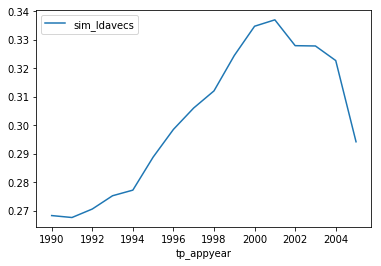

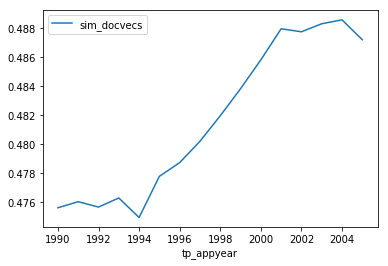

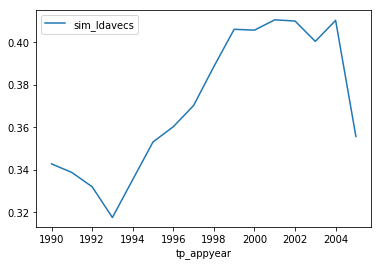

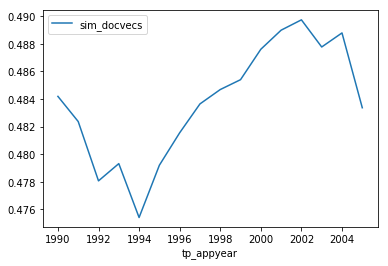

In [62]:
%matplotlib inline
tp_all_lda.plot.line()
tp_all_dv.plot.line()
tp_sw_lda_tp.plot.line()
tp_sw_dv_tp.plot.line()

In [73]:
# Don't average similarity by tp
all_lda = ts[["sim_ldavecs", "{0}_appyear".format(yr_col)]].groupby("{0}_appyear".format(yr_col)).mean()
all_dv = ts[["sim_docvecs", "{0}_appyear".format(yr_col)]].groupby("{0}_appyear".format(yr_col)).mean()
sw_lda_tp = ts.loc[(ts["{0}_is_sw".format(yr_col)]==True), ["sim_ldavecs", "{0}_appyear".format(yr_col)]].groupby("{0}_appyear".format(yr_col)).mean()
sw_dv_tp = ts.loc[(ts["{0}_is_sw".format(yr_col)]==True), ["sim_docvecs", "{0}_appyear".format(yr_col)]].groupby("{0}_appyear".format(yr_col)).mean()
sw_lda_op = ts.loc[(ts["op_is_sw"]==True), ["sim_ldavecs", "{0}_appyear".format(yr_col)]].groupby("{0}_appyear".format(yr_col)).mean()
sw_dv_op = ts.loc[(ts["op_is_sw"]==True), ["sim_docvecs", "{0}_appyear".format(yr_col)]].groupby("{0}_appyear".format(yr_col)).mean()
nsw_lda_op = ts.loc[(ts["tp_is_sw"]==False) & (ts["op_is_sw"]==True), ["sim_ldavecs", "{0}_appyear".format(yr_col)]].groupby("{0}_appyear".format(yr_col)).mean()
nsw_dv_op = ts.loc[(ts["tp_is_sw"]==False) & (ts["op_is_sw"]==True), ["sim_docvecs", "{0}_appyear".format(yr_col)]].groupby("{0}_appyear".format(yr_col)).mean()

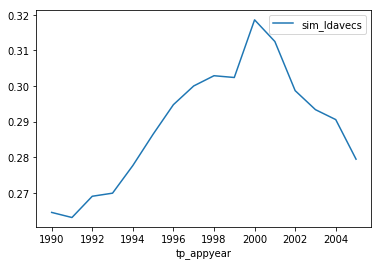

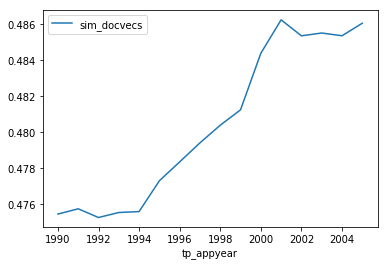

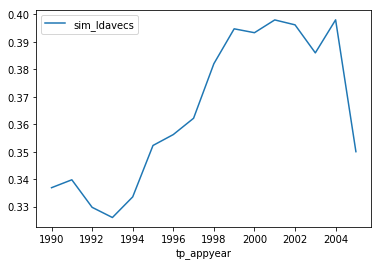

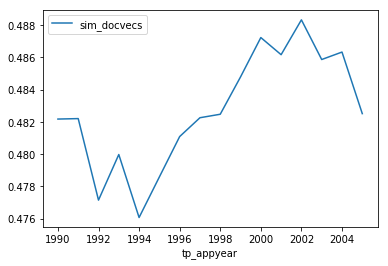

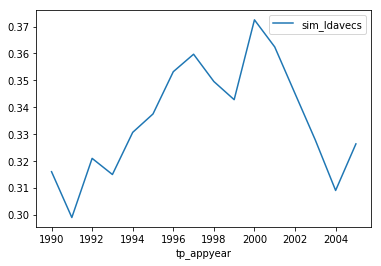

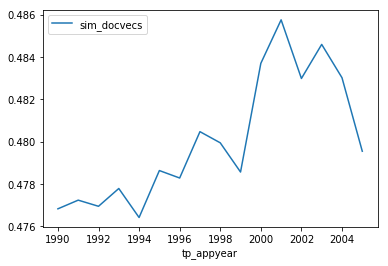

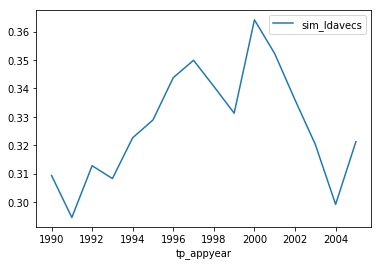

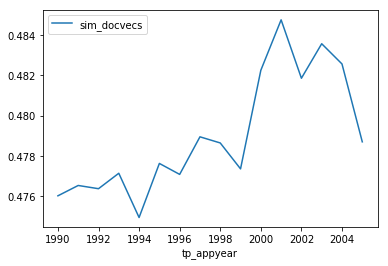

In [74]:
%matplotlib inline
all_lda.plot.line()
all_dv.plot.line()
sw_lda_tp.plot.line()
sw_dv_tp.plot.line()
sw_lda_op.plot.line()
sw_dv_op.plot.line()
nsw_lda_op.plot.line()
nsw_dv_op.plot.line()

### 2.2 Localization with software patent entry

In [39]:
len(ts)

1195656

In [65]:
sw_lda_mt = ts.loc[(ts["op_is_sw"]==True) & (ts["inv_msa_match"] == True),
                   ["sim_ldavecs", "tp_appyear"]].groupby("tp_appyear").mean()
sw_lda_mf = ts.loc[(ts["op_is_sw"]==True) & (ts["inv_msa_match"] == False),
                   ["sim_ldavecs", "tp_appyear"]].groupby("tp_appyear").mean()
sw_lda_m = sw_lda_mt-sw_lda_mf
sw_dv_mt = ts.loc[(ts["op_is_sw"]==True) & (ts["inv_msa_match"] == True),
                   ["sim_docvecs", "tp_appyear"]].groupby("tp_appyear").mean()
sw_dv_mf = ts.loc[(ts["op_is_sw"]==True) & (ts["inv_msa_match"] == False),
                   ["sim_docvecs", "tp_appyear"]].groupby("tp_appyear").mean()
sw_dv_m = sw_dv_mt-sw_dv_mf

lda_mt = ts.loc[ (ts["inv_msa_match"] == True),
                   ["sim_ldavecs", "tp_appyear"]].groupby("tp_appyear").mean()
lda_mf = ts.loc[(ts["inv_msa_match"] == False),
                   ["sim_ldavecs", "tp_appyear"]].groupby("tp_appyear").mean()
lda_m = lda_mt-lda_mf
dv_mt = ts.loc[(ts["inv_msa_match"] == True),
                   ["sim_docvecs", "tp_appyear"]].groupby("tp_appyear").mean()
dv_mf = ts.loc[(ts["inv_msa_match"] == False),
                   ["sim_docvecs", "tp_appyear"]].groupby("tp_appyear").mean()
dv_m = dv_mt-dv_mf

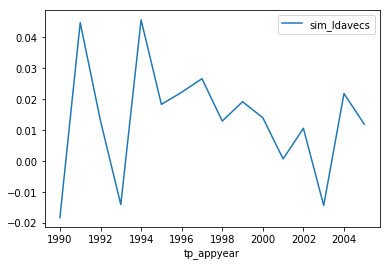

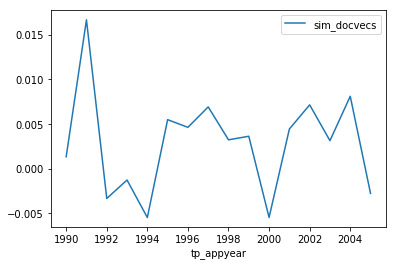

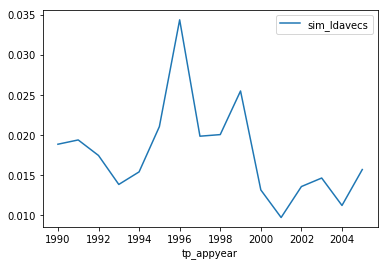

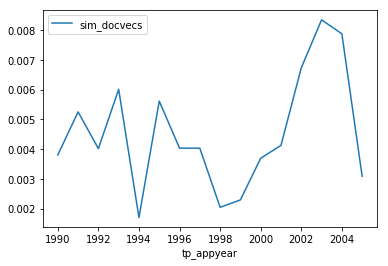

In [66]:
%matplotlib inline
sw_lda_m.plot.line()
sw_dv_m.plot.line()
lda_m.plot.line()
dv_m.plot.line()

In [67]:
sw_lda_mt_s = ts.loc[(ts["op_is_sw"]==True) & (ts["inv_msa_match"] == True),
                   ["sim_ldavecs", "tp_appyear"]].groupby("tp_appyear").size()
sw_lda_mf_s = ts.loc[(ts["op_is_sw"]==True) & (ts["inv_msa_match"] == False),
                   ["sim_ldavecs", "tp_appyear"]].groupby("tp_appyear").size()

In [68]:
sw_lda_mt_s

tp_appyear
1990.0     57
1991.0     59
1992.0     66
1993.0     34
1994.0     43
1995.0    311
1996.0    364
1997.0    311
1998.0    227
1999.0    140
2000.0    491
2001.0    509
2002.0    390
2003.0    206
2004.0    141
2005.0    303
dtype: int64

In [69]:
sw_lda_mf_s

tp_appyear
1990.0     1755
1991.0     1657
1992.0     1612
1993.0     1287
1994.0     1046
1995.0     6325
1996.0     6795
1997.0     6295
1998.0     4163
1999.0     2297
2000.0    10345
2001.0     9178
2002.0     7475
2003.0     5128
2004.0     3153
2005.0     5460
dtype: int64